In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
filename = 'AllPublicnew.sdf'
filepath = f'{filename}'

download_url = f'https://zenodo.org/records/3540701/files/{filename}'

if not os.path.exists(filepath):
    !wget {download_url} -O {filepath}
else:
    print("File already exists:", filepath)

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
def in_google_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False


In [4]:
# !pip install jaqpotpy
# !pip install rdkit
# !pip install torch-geometric
# !pip install scikit-learn
# !pip install torch

In [5]:
import random
import numpy as np
import torch

seed = 42

random.seed(seed)
np.random.seed(seed)

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()

torch.manual_seed(seed)

if cuda:
    print(f"Device: \n- {torch.cuda.get_device_name()}")
    torch.cuda.manual_seed(seed)
else:
    print(f"Device: {'CPU'}")


Device: 
- NVIDIA GeForce GTX 1050 Ti with Max-Q Design


In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
from pathlib import Path

import sys

if '..' not in sys.path:
    sys.path.append('..')
    
from utils.utils import class_balanced_random_split

working_dir = Path.cwd()
filename = 'AllPublicnew.sdf'


if in_google_colab():
    data_dir = working_dir
else:
    data_dir = working_dir.parent/'data'/'ready_biodegradability'
    
   
    
dataset_filepath = data_dir/filename


X, y = [], []
sdf_supplier = Chem.SDMolSupplier(str(dataset_filepath))

for mol in sdf_supplier:
    if mol is not None:
        smiles = mol.GetProp('SMILES')
        # smiles = Chem.MolToSmiles(mol)
        ready_biodegradability = int(mol.GetProp('ReadyBiodegradability'))

        X.append(smiles)
        y.append(ready_biodegradability)



In [7]:
import numpy as np


n_all = len(y)
print(f"Whole Dataset ({100*(np.array(y)==1).sum()/n_all:.1f}% positive):")
print(f"- Positive Samples: {(np.array(y)==1).sum():,}")
print(f"- Negative Samples: {(np.array(y)==0).sum():,}")
print('\n')

# TODO: Need oversampling on train data AFTER spliting on train-validtaion as well

# Create test split
X_train_val, X_test, y_train_val, y_test = class_balanced_random_split(X, y, seed=seed)

# Create train and validation splits
X_train, X_val, y_train, y_val = class_balanced_random_split(X_train_val, y_train_val, seed=seed)


# n_train = len(y_train)
# print(f"Train Split ({100*(np.array(y_train)==1).sum()/n_train:.1f}% positive):")
# print(f"- Positive Train Samples: {(np.array(y_train)==1).sum():,}")
# print(f"- Negative Train Samples: {(np.array(y_train)==0).sum():,}")
# print('\n')

# n_val = len(y_val)
# print(f"Validation Split ({100*(np.array(y_val)==1).sum()/n_val:.1f}% positive):")
# print(f"- Positive Validation Samples: {(np.array(y_val)==1).sum():,}")
# print(f"- Negative Validation Samples: {(np.array(y_val)==0).sum():,}")
# print('\n')



# n_test = len(y_test)
# print(f"Test Split ({100*(np.array(y_test)==1).sum()/n_test:.1f}% positive):")
# print(f"- Positive Test Samples: {(np.array(y_test)==1).sum():,}")
# print(f"- Negative Test Samples: {(np.array(y_test)==0).sum():,}")
# print('\n')

Whole Dataset (35.5% positive):
- Positive Samples: 1,133
- Negative Samples: 2,059




### Structural data of the dataset for graph node feature creation

In [8]:
from rdkit import Chem
Symb , Hs , Impv , Fc , Hb , ExpV , Deg = set() , set() , set() , set() , set() , set() , set()
bond_type , conj = set() , set()

for smile in X:
    for atom in Chem.MolFromSmiles(smile).GetAtoms():
        Symb.add(atom.GetSymbol())
        Hs.add(atom.GetTotalNumHs())
        Impv.add(atom.GetImplicitValence())
        Fc.add(atom.GetFormalCharge())
        Hb.add(atom.GetHybridization())
        ExpV.add(atom.GetExplicitValence())
        Deg.add(atom.GetDegree())
        
    for bond in Chem.MolFromSmiles(smile).GetBonds():
        bond_type.add(bond.GetBondType())
        conj.add(bond.GetIsConjugated())
        
print('Symb: ', Symb)
print('Hs: ', Hs)
print('Impv: ', Impv)
print('Fc: ', Fc)
print('Hb: ', Hb)
print('ExpV: ', ExpV)
print('Deg: ', Deg)


print("Bond Types:", bond_type)
print("Is_Conjugated:", conj)

Symb:  {'Sn', 'Bi', 'Si', 'C', 'Cl', 'Cu', 'F', 'O', 'S', 'I', 'B', 'N', 'P', 'Br'}
Hs:  {0, 1, 2, 3, 4}
Impv:  {0, 1, 2, 3, 4}
Fc:  {0, 1, -1}
Hb:  {rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2, rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP3D2}
ExpV:  {0, 1, 2, 3, 4, 5, 6}
Deg:  {0, 1, 2, 3, 4}
Bond Types: {rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC}
Is_Conjugated: {False, True}


### Create the graph datasets

In [9]:
from rdkit import Chem

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception(f'input{x} not in allowable set{allowable_set}')
    return list(map(lambda s: x == s , allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x==s, allowable_set))

Symbols = list(Symb)

Degree = list(Deg)
Hs_Atoms = list(Hs)
Implicit_Val = list(Impv)
Formal_Charge = list(Fc)
Explicit_Val = list(ExpV)
Hybridization = list(Hb)

def atom_feature(atom):
    return torch.tensor(one_of_k_encoding_unk(atom.GetSymbol(), Symbols) +
                        one_of_k_encoding(atom.GetTotalNumHs(), Hs_Atoms) +
                        one_of_k_encoding(atom.GetDegree(), Degree) +
                        one_of_k_encoding(atom.GetImplicitValence(), Implicit_Val) +
                        one_of_k_encoding(atom.GetFormalCharge(), Formal_Charge) +
                        one_of_k_encoding(atom.GetHybridization(), Hybridization) +
                        one_of_k_encoding(atom.GetExplicitValence(), Explicit_Val) +
                        [atom.GetIsAromatic()], dtype=torch.int16)

In [28]:
from torch_geometric.data import Data

def nodes_and_adjacency(smile,y):

    mol = Chem.MolFromSmiles(smile)
    # Create node Features
    feats = []
    attr = []
    for atom in mol.GetAtoms():
        feats.append(atom_feature(atom)) # Get the 5 feats in a single atom of a mol
    mol_node_features = torch.stack(feats).float() # Stack them in an array [num_nodes x atom_features]

    # Create Adjacency Matrix
    ix1, ix2 = [], []

    for bond in mol.GetBonds():

        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        ix1 += [start, end]
        ix2 += [end, start]

    adj_norm = torch.asarray([ix1, ix2], dtype=torch.int64) # Needs to be in COO Format

    return Data(x=mol_node_features,
                edge_index=adj_norm,
                y=y)

In [30]:
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import torch

from torch_geometric.transforms import NormalizeScale


class GraphDataset(Dataset):

    def __init__(self, smiles, y, transform=None):
        super(GraphDataset,self).__init__()
        
        self.transform = transform
        dataset_info = [nodes_and_adjacency(smile, y) for smile, y in (zip(smiles, y))]

        self.df = [info for info in dataset_info]

    def __getitem__(self, idx):
        
        data = self.df[idx]
        
        if self.transform is not None:
            data = self.transform(data)
            
        return data

    def __len__(self):
        return len(self.df)


### Training function

In [31]:
from tqdm import tqdm

# Train function
def train(epoch, n_epochs, loader, model, loss_fn, optimizer, device):
    
    running_loss = 0
    total_samples = 0
    tqdm_loader = tqdm(loader, desc=f'Epoch {epoch}/{n_epochs}')
    
    model.train()
    for _, data in enumerate(tqdm_loader):
        
        data = data.to(device)
        
        optimizer.zero_grad()

        outputs = model(x=data.x, edge_index=data.edge_index, batch=data.batch).squeeze(-1)
         
        loss = loss_fn(outputs.float(), data.y.float())
    

        running_loss += loss.item() * data.y.size(0)
        total_samples += data.y.size(0)
        
        loss.backward()
        optimizer.step()
        
        # Update tqdm description with additional information
        tqdm_loader.set_postfix(loss=running_loss/total_samples)
        
    avg_loss = running_loss / len(loader.dataset)
    
    tqdm_loader.set_postfix(loss=running_loss)
    tqdm_loader.close()
            
    return avg_loss


# train_loss = train(epoch, n_epochs, train_loader, model, loss_fn, optimizer, device)
    

### Testing function

In [73]:
import torch.nn.functional as F
import sklearn.metrics as metrics

def test(loader, model, loss_fn, device, decision_threshold=0.5):
    
    running_loss = 0
    total_samples = 0
    
    all_preds = []
    all_probs = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(loader):
        
            data = data.to(device)
            
            outputs = model(x=data.x, edge_index=data.edge_index, batch=data.batch).squeeze(-1)
            
            probs = F.sigmoid(outputs)
            preds = (probs > decision_threshold).int()
            
            all_probs.extend(probs.tolist())
            all_preds.extend(preds.tolist())
            all_labels.extend(data.y.tolist())
            
            loss = loss_fn(outputs.float(), data.y.float())
            
            running_loss += loss.item() * data.y.size(0)
            total_samples += data.y.size(0)
        
        avg_loss = running_loss / len(loader.dataset)
    
    metrics_dict = compute_metrics(all_labels, all_preds)
    metrics_dict['roc_auc'] = metrics.roc_auc_score(all_labels, all_probs)
    metrics_dict['loss'] = avg_loss
    conf_mat = metrics.confusion_matrix(all_labels, all_preds).ravel()

#     tn, fp, fn, tp = metrics.confusion_matrix(all_labels, all_preds).ravel()
#     conf_mat = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    
        
    return avg_loss, metrics_dict, conf_mat
                                                                         


def compute_metrics(y_true, y_pred):
    
    accuracy = metrics.accuracy_score(y_true, y_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, zero_division=0)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    
    metrics_dict = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc
    }
    
    return metrics_dict


### Create Dataloaders

In [74]:
from torch_geometric.loader import DataLoader
import random 
import numpy as np

transform = None
# transform = NormalizeScale()



train_dataset = GraphDataset(X_train, y_train, transform=transform)
val_dataset = GraphDataset(X_val, y_val, transform=transform)
test_dataset = GraphDataset(X_test, y_test, transform=transform)


kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}

train_loader = DataLoader(dataset=train_dataset, batch_size=784, shuffle=True, **kwargs)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, **kwargs)



### Create BCE Loss Function with Label Smoothing

In [75]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss

class LabelSmoothingBCEWithLogitsLoss(nn.Module):
    def __init__(self,
                 smoothing=[0.0, 0.0],
                 weight=None,
                 size_average=None,
                 reduce=None,
                 reduction='mean',
                 pos_weight=None,):
        
        super(LabelSmoothingBCEWithLogitsLoss, self).__init__()
        
        self.smoothing = smoothing
        self.bce = BCEWithLogitsLoss(weight, size_average, reduce, reduction, pos_weight)
        

    def forward(self, outputs, targets):
        
        label_smoothing = [torch.tensor(self.smoothing[0]).float(), torch.tensor(1-self.smoothing[1]).float()]
        smoothed_labels = torch.where(targets < 0.5, label_smoothing[0], label_smoothing[1])
        loss = self.bce(outputs, smoothed_labels)
        
        return loss


### Import classes of Graph Neural Networks

#### Graph Convolutional Network

In [76]:
from models.graph_convolutional_network import GraphConvolutionalNetwork

gcn_model = GraphConvolutionalNetwork(input_dim=44,
                                      hidden_dims=[64, 64],
                                      output_dim=1,
                                      activation=nn.ReLU(),
                                      dropout=0.3,
                                      graph_norm=False,
                                      pooling='mean'
                                     ).to(device)




#### Graph Attention Network

In [77]:
from models.graph_attention_network import GraphAttentionNetwork


gat_model = GraphAttentionNetwork(input_dim=44,
                                  hidden_dims=[32, 32, 32],
                                  heads=8,
                                  output_dim=1,
                                  activation=nn.ReLU(),
                                  dropout=0.2,
                                  graph_norm=False,
                                  pooling='mean'
                                 ).to(device)

### Training Loop

In [94]:
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
import torch_geometric.nn.models
import torch
import copy

smoothing = [0.0, 0.2]

# pos_weight = torch.tensor(0.65/0.35).to(device)
pos_weight = None

n_epochs = 100


# model = GraphConvolutionalNetwork(input_dim=44,
#                                   hidden_dims=[32, 32, 32],
#                                   output_dim=1,
#                                   activation=nn.ReLU(),
#                                   dropout=0.2,
#                                   graph_norm=False,
#                                   pooling='mean'
#                                  ).to(device)


model = GraphAttentionNetwork(input_dim=44,
                              hidden_dims=[64, 64, 64],
                              heads=8,
                              output_dim=1,
                              activation=nn.ReLU(),
                              dropout=0.0,
                              graph_norm=False,
                              pooling='mean'
                             ).to(device)





optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_fn = LabelSmoothingBCEWithLogitsLoss(smoothing=smoothing, pos_weight=pos_weight)
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


train_losses = []
val_losses = []
val_metrics_all = []


best_epoch = 1
optimization_metric = 'f1'
best_optimization_metric = float('inf') if optimization_metric=='loss' else -float('inf')
best_model_params = None

for epoch in range(1, n_epochs + 1):
    train_loss = train(epoch, n_epochs, train_loader, model, loss_fn, optimizer, device)
    val_loss, val_metrics, val_conf_mat = test(val_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics_all.append(val_metrics)
    print(f"Train Loss: {train_loss:.4f}", end=' | ')
    print(f"Val Loss: {val_loss:.4f}", end=' | ')
    print(f"Accuracy: {val_metrics['accuracy']:.4f}", end=' | ')
    print(f"F1: {val_metrics['f1']:.4f}", end=' | ')
    print(f"MCC: {val_metrics['mcc']:.4f}", end=' | ')
    print(f"ROC_AUC: {val_metrics['roc_auc']:.4f}", end=' | ')
    
    if optimization_metric == 'loss':
        if val_metrics['loss'] < best_optimization_metric:
            best_optimization_metric = val_metrics['loss']
            best_model_params = copy.deepcopy(model.state_dict())
            best_epoch = epoch
    else:  
        if val_metrics[optimization_metric] > best_optimization_metric:
            best_optimization_metric = val_metrics[optimization_metric]
            best_model_params = copy.deepcopy(model.state_dict())
            best_epoch = epoch
        

print(f"\n\nBest model corresponding to validation {optimization_metric} was found at epoch {best_epoch}, with a validation {optimization_metric} of {best_optimization_metric:.4f}")

# model.load_state_dict(best_model_params)


test_loss, test_metrics, test_conf_mat = test(test_loader, model, loss_fn, device)

print("\nPerformance on Test Set on Final epoch:")
for metric_name, metric in test_metrics.items():
    print(f'- {metric_name}: {metric:.4f}')
    

model.load_state_dict(best_model_params)


test_loss, test_metrics, test_conf_mat = test(test_loader, model, loss_fn, device)

print(f"\nPerformance on Test Set on best epoch={best_epoch}:")
for metric_name, metric in test_metrics.items():
    print(f'- {metric_name}: {metric:.4f}')

Epoch 1/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.93it/s, loss=0.672]


Train Loss: 0.6716 | Val Loss: 0.6197 | Accuracy: 0.6446 | F1: 0.0000 | MCC: 0.0000 | ROC_AUC: 0.6971 | 

Epoch 2/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.04it/s, loss=0.606]


Train Loss: 0.6063 | Val Loss: 0.5860 | Accuracy: 0.6446 | F1: 0.0000 | MCC: 0.0000 | ROC_AUC: 0.7435 | 

Epoch 3/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.09it/s, loss=0.581]


Train Loss: 0.5810 | Val Loss: 0.5784 | Accuracy: 0.6446 | F1: 0.0000 | MCC: 0.0000 | ROC_AUC: 0.7327 | 

Epoch 4/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.38it/s, loss=0.569]


Train Loss: 0.5690 | Val Loss: 0.5683 | Accuracy: 0.6446 | F1: 0.0000 | MCC: 0.0000 | ROC_AUC: 0.7327 | 

Epoch 5/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.04it/s, loss=0.553]


Train Loss: 0.5529 | Val Loss: 0.5551 | Accuracy: 0.6446 | F1: 0.0000 | MCC: 0.0000 | ROC_AUC: 0.7341 | 

Epoch 6/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.23it/s, loss=0.538]


Train Loss: 0.5384 | Val Loss: 0.5478 | Accuracy: 0.6642 | F1: 0.1988 | MCC: 0.1627 | ROC_AUC: 0.7363 | 

Epoch 7/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.09it/s, loss=0.528]


Train Loss: 0.5284 | Val Loss: 0.5432 | Accuracy: 0.6765 | F1: 0.3265 | MCC: 0.2148 | ROC_AUC: 0.7401 | 

Epoch 8/100: 100%|████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.04it/s, loss=0.52]


Train Loss: 0.5202 | Val Loss: 0.5407 | Accuracy: 0.6838 | F1: 0.3645 | MCC: 0.2403 | ROC_AUC: 0.7450 | 

Epoch 9/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.01it/s, loss=0.514]


Train Loss: 0.5140 | Val Loss: 0.5388 | Accuracy: 0.6838 | F1: 0.3645 | MCC: 0.2403 | ROC_AUC: 0.7534 | 

Epoch 10/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.09it/s, loss=0.507]


Train Loss: 0.5070 | Val Loss: 0.5298 | Accuracy: 0.7059 | F1: 0.4495 | MCC: 0.3080 | ROC_AUC: 0.7629 | 

Epoch 11/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.15it/s, loss=0.499]


Train Loss: 0.4990 | Val Loss: 0.5206 | Accuracy: 0.7108 | F1: 0.4779 | MCC: 0.3237 | ROC_AUC: 0.7765 | 

Epoch 12/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s, loss=0.49]


Train Loss: 0.4904 | Val Loss: 0.5129 | Accuracy: 0.7108 | F1: 0.4434 | MCC: 0.3205 | ROC_AUC: 0.7899 | 

Epoch 13/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.93it/s, loss=0.482]


Train Loss: 0.4815 | Val Loss: 0.5029 | Accuracy: 0.7279 | F1: 0.4739 | MCC: 0.3691 | ROC_AUC: 0.8046 | 

Epoch 14/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.01it/s, loss=0.474]


Train Loss: 0.4741 | Val Loss: 0.4927 | Accuracy: 0.7525 | F1: 0.5551 | MCC: 0.4327 | ROC_AUC: 0.8169 | 

Epoch 15/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.82it/s, loss=0.466]


Train Loss: 0.4660 | Val Loss: 0.4886 | Accuracy: 0.7549 | F1: 0.5238 | MCC: 0.4464 | ROC_AUC: 0.8262 | 

Epoch 16/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.01it/s, loss=0.459]


Train Loss: 0.4595 | Val Loss: 0.4784 | Accuracy: 0.7574 | F1: 0.5714 | MCC: 0.4449 | ROC_AUC: 0.8330 | 

Epoch 17/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.15it/s, loss=0.454]


Train Loss: 0.4538 | Val Loss: 0.4729 | Accuracy: 0.7598 | F1: 0.5847 | MCC: 0.4510 | ROC_AUC: 0.8387 | 

Epoch 18/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.98it/s, loss=0.45]


Train Loss: 0.4500 | Val Loss: 0.4719 | Accuracy: 0.7672 | F1: 0.5740 | MCC: 0.4724 | ROC_AUC: 0.8458 | 

Epoch 19/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.09it/s, loss=0.445]


Train Loss: 0.4451 | Val Loss: 0.4615 | Accuracy: 0.7696 | F1: 0.6050 | MCC: 0.4754 | ROC_AUC: 0.8514 | 

Epoch 20/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.12it/s, loss=0.441]


Train Loss: 0.4408 | Val Loss: 0.4623 | Accuracy: 0.7647 | F1: 0.5636 | MCC: 0.4673 | ROC_AUC: 0.8550 | 

Epoch 21/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.98it/s, loss=0.438]


Train Loss: 0.4381 | Val Loss: 0.4546 | Accuracy: 0.7672 | F1: 0.5852 | MCC: 0.4704 | ROC_AUC: 0.8598 | 

Epoch 22/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.23it/s, loss=0.435]


Train Loss: 0.4347 | Val Loss: 0.4522 | Accuracy: 0.7745 | F1: 0.5965 | MCC: 0.4898 | ROC_AUC: 0.8621 | 

Epoch 23/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.23it/s, loss=0.433]


Train Loss: 0.4327 | Val Loss: 0.4498 | Accuracy: 0.7770 | F1: 0.5991 | MCC: 0.4965 | ROC_AUC: 0.8655 | 

Epoch 24/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.98it/s, loss=0.431]


Train Loss: 0.4309 | Val Loss: 0.4447 | Accuracy: 0.7794 | F1: 0.6087 | MCC: 0.5017 | ROC_AUC: 0.8699 | 

Epoch 25/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.35it/s, loss=0.429]


Train Loss: 0.4294 | Val Loss: 0.4455 | Accuracy: 0.7843 | F1: 0.6036 | MCC: 0.5187 | ROC_AUC: 0.8724 | 

Epoch 26/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.20it/s, loss=0.425]


Train Loss: 0.4249 | Val Loss: 0.4382 | Accuracy: 0.7794 | F1: 0.6154 | MCC: 0.5006 | ROC_AUC: 0.8764 | 

Epoch 27/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.29it/s, loss=0.424]


Train Loss: 0.4240 | Val Loss: 0.4404 | Accuracy: 0.7819 | F1: 0.5973 | MCC: 0.5128 | ROC_AUC: 0.8780 | 

Epoch 28/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.04it/s, loss=0.421]


Train Loss: 0.4215 | Val Loss: 0.4358 | Accuracy: 0.7917 | F1: 0.6288 | MCC: 0.5338 | ROC_AUC: 0.8796 | 

Epoch 29/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.75it/s, loss=0.421]


Train Loss: 0.4210 | Val Loss: 0.4369 | Accuracy: 0.7892 | F1: 0.6228 | MCC: 0.5279 | ROC_AUC: 0.8800 | 

Epoch 30/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.12it/s, loss=0.42]


Train Loss: 0.4196 | Val Loss: 0.4362 | Accuracy: 0.7892 | F1: 0.6195 | MCC: 0.5291 | ROC_AUC: 0.8811 | 

Epoch 31/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.77it/s, loss=0.417]


Train Loss: 0.4172 | Val Loss: 0.4312 | Accuracy: 0.7843 | F1: 0.6271 | MCC: 0.5125 | ROC_AUC: 0.8831 | 

Epoch 32/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.80it/s, loss=0.415]


Train Loss: 0.4149 | Val Loss: 0.4395 | Accuracy: 0.7770 | F1: 0.5845 | MCC: 0.5010 | ROC_AUC: 0.8833 | 

Epoch 33/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.31it/s, loss=0.414]


Train Loss: 0.4145 | Val Loss: 0.4283 | Accuracy: 0.7941 | F1: 0.6500 | MCC: 0.5360 | ROC_AUC: 0.8850 | 

Epoch 34/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.85it/s, loss=0.412]


Train Loss: 0.4118 | Val Loss: 0.4342 | Accuracy: 0.7770 | F1: 0.5882 | MCC: 0.4997 | ROC_AUC: 0.8848 | 

Epoch 35/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.36it/s, loss=0.412]


Train Loss: 0.4118 | Val Loss: 0.4275 | Accuracy: 0.7892 | F1: 0.6293 | MCC: 0.5261 | ROC_AUC: 0.8870 | 

Epoch 36/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.38it/s, loss=0.408]


Train Loss: 0.4082 | Val Loss: 0.4259 | Accuracy: 0.7868 | F1: 0.6360 | MCC: 0.5180 | ROC_AUC: 0.8877 | 

Epoch 37/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.24it/s, loss=0.407]


Train Loss: 0.4072 | Val Loss: 0.4282 | Accuracy: 0.7892 | F1: 0.6228 | MCC: 0.5279 | ROC_AUC: 0.8887 | 

Epoch 38/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.37it/s, loss=0.405]


Train Loss: 0.4049 | Val Loss: 0.4238 | Accuracy: 0.7892 | F1: 0.6504 | MCC: 0.5233 | ROC_AUC: 0.8894 | 

Epoch 39/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.71it/s, loss=0.404]


Train Loss: 0.4045 | Val Loss: 0.4263 | Accuracy: 0.7941 | F1: 0.6410 | MCC: 0.5378 | ROC_AUC: 0.8897 | 

Epoch 40/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.75it/s, loss=0.405]


Train Loss: 0.4046 | Val Loss: 0.4244 | Accuracy: 0.7966 | F1: 0.6527 | MCC: 0.5423 | ROC_AUC: 0.8903 | 

Epoch 41/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.46it/s, loss=0.402]


Train Loss: 0.4025 | Val Loss: 0.4230 | Accuracy: 0.7966 | F1: 0.6584 | MCC: 0.5415 | ROC_AUC: 0.8903 | 

Epoch 42/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.98it/s, loss=0.402]


Train Loss: 0.4025 | Val Loss: 0.4259 | Accuracy: 0.7966 | F1: 0.6527 | MCC: 0.5423 | ROC_AUC: 0.8896 | 

Epoch 43/100: 100%|████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.91it/s, loss=0.4]


Train Loss: 0.4004 | Val Loss: 0.4218 | Accuracy: 0.7990 | F1: 0.6694 | MCC: 0.5469 | ROC_AUC: 0.8907 | 

Epoch 44/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.85it/s, loss=0.399]


Train Loss: 0.3992 | Val Loss: 0.4255 | Accuracy: 0.7917 | F1: 0.6352 | MCC: 0.5319 | ROC_AUC: 0.8919 | 

Epoch 45/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.63it/s, loss=0.396]


Train Loss: 0.3963 | Val Loss: 0.4208 | Accuracy: 0.8064 | F1: 0.6853 | MCC: 0.5643 | ROC_AUC: 0.8916 | 

Epoch 46/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s, loss=0.397]


Train Loss: 0.3966 | Val Loss: 0.4244 | Accuracy: 0.7966 | F1: 0.6527 | MCC: 0.5423 | ROC_AUC: 0.8920 | 

Epoch 47/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s, loss=0.395]


Train Loss: 0.3951 | Val Loss: 0.4206 | Accuracy: 0.7966 | F1: 0.6612 | MCC: 0.5412 | ROC_AUC: 0.8925 | 

Epoch 48/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s, loss=0.393]


Train Loss: 0.3934 | Val Loss: 0.4198 | Accuracy: 0.7990 | F1: 0.6667 | MCC: 0.5470 | ROC_AUC: 0.8935 | 

Epoch 49/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s, loss=0.394]


Train Loss: 0.3941 | Val Loss: 0.4203 | Accuracy: 0.7941 | F1: 0.6557 | MCC: 0.5353 | ROC_AUC: 0.8942 | 

Epoch 50/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s, loss=0.394]


Train Loss: 0.3936 | Val Loss: 0.4188 | Accuracy: 0.8015 | F1: 0.6721 | MCC: 0.5529 | ROC_AUC: 0.8945 | 

Epoch 51/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s, loss=0.392]


Train Loss: 0.3916 | Val Loss: 0.4205 | Accuracy: 0.7892 | F1: 0.6446 | MCC: 0.5236 | ROC_AUC: 0.8942 | 

Epoch 52/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s, loss=0.395]


Train Loss: 0.3945 | Val Loss: 0.4195 | Accuracy: 0.8015 | F1: 0.6721 | MCC: 0.5529 | ROC_AUC: 0.8939 | 

Epoch 53/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.62it/s, loss=0.392]


Train Loss: 0.3918 | Val Loss: 0.4244 | Accuracy: 0.7892 | F1: 0.6446 | MCC: 0.5236 | ROC_AUC: 0.8942 | 

Epoch 54/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.78it/s, loss=0.39]


Train Loss: 0.3899 | Val Loss: 0.4182 | Accuracy: 0.8162 | F1: 0.7104 | MCC: 0.5876 | ROC_AUC: 0.8943 | 

Epoch 55/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.39it/s, loss=0.39]


Train Loss: 0.3902 | Val Loss: 0.4238 | Accuracy: 0.7941 | F1: 0.6500 | MCC: 0.5360 | ROC_AUC: 0.8945 | 

Epoch 56/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s, loss=0.387]


Train Loss: 0.3867 | Val Loss: 0.4176 | Accuracy: 0.8113 | F1: 0.7004 | MCC: 0.5760 | ROC_AUC: 0.8950 | 

Epoch 57/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.71it/s, loss=0.387]


Train Loss: 0.3874 | Val Loss: 0.4199 | Accuracy: 0.7917 | F1: 0.6502 | MCC: 0.5295 | ROC_AUC: 0.8959 | 

Epoch 58/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s, loss=0.385]


Train Loss: 0.3847 | Val Loss: 0.4167 | Accuracy: 0.8064 | F1: 0.6827 | MCC: 0.5645 | ROC_AUC: 0.8949 | 

Epoch 59/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s, loss=0.384]


Train Loss: 0.3842 | Val Loss: 0.4178 | Accuracy: 0.7990 | F1: 0.6667 | MCC: 0.5470 | ROC_AUC: 0.8949 | 

Epoch 60/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s, loss=0.383]


Train Loss: 0.3829 | Val Loss: 0.4160 | Accuracy: 0.8015 | F1: 0.6747 | MCC: 0.5527 | ROC_AUC: 0.8957 | 

Epoch 61/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s, loss=0.383]


Train Loss: 0.3827 | Val Loss: 0.4179 | Accuracy: 0.7917 | F1: 0.6502 | MCC: 0.5295 | ROC_AUC: 0.8961 | 

Epoch 62/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.78it/s, loss=0.383]


Train Loss: 0.3825 | Val Loss: 0.4152 | Accuracy: 0.8039 | F1: 0.6800 | MCC: 0.5585 | ROC_AUC: 0.8968 | 

Epoch 63/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s, loss=0.381]


Train Loss: 0.3806 | Val Loss: 0.4159 | Accuracy: 0.8039 | F1: 0.6800 | MCC: 0.5585 | ROC_AUC: 0.8961 | 

Epoch 64/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.06it/s, loss=0.38]


Train Loss: 0.3800 | Val Loss: 0.4188 | Accuracy: 0.7990 | F1: 0.6639 | MCC: 0.5473 | ROC_AUC: 0.8955 | 

Epoch 65/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s, loss=0.379]


Train Loss: 0.3793 | Val Loss: 0.4168 | Accuracy: 0.8088 | F1: 0.6929 | MCC: 0.5701 | ROC_AUC: 0.8956 | 

Epoch 66/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s, loss=0.38]


Train Loss: 0.3799 | Val Loss: 0.4192 | Accuracy: 0.8015 | F1: 0.6667 | MCC: 0.5535 | ROC_AUC: 0.8964 | 

Epoch 67/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s, loss=0.38]


Train Loss: 0.3798 | Val Loss: 0.4146 | Accuracy: 0.8088 | F1: 0.6953 | MCC: 0.5702 | ROC_AUC: 0.8970 | 

Epoch 68/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s, loss=0.379]


Train Loss: 0.3792 | Val Loss: 0.4155 | Accuracy: 0.8088 | F1: 0.6880 | MCC: 0.5703 | ROC_AUC: 0.8978 | 

Epoch 69/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s, loss=0.377]


Train Loss: 0.3771 | Val Loss: 0.4134 | Accuracy: 0.8113 | F1: 0.6980 | MCC: 0.5759 | ROC_AUC: 0.8985 | 

Epoch 70/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s, loss=0.376]


Train Loss: 0.3760 | Val Loss: 0.4155 | Accuracy: 0.8088 | F1: 0.6905 | MCC: 0.5701 | ROC_AUC: 0.8978 | 

Epoch 71/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.78it/s, loss=0.375]


Train Loss: 0.3750 | Val Loss: 0.4161 | Accuracy: 0.8113 | F1: 0.6980 | MCC: 0.5759 | ROC_AUC: 0.8967 | 

Epoch 72/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s, loss=0.374]


Train Loss: 0.3745 | Val Loss: 0.4168 | Accuracy: 0.8137 | F1: 0.6960 | MCC: 0.5820 | ROC_AUC: 0.8967 | 

Epoch 73/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s, loss=0.374]


Train Loss: 0.3736 | Val Loss: 0.4131 | Accuracy: 0.8113 | F1: 0.6980 | MCC: 0.5759 | ROC_AUC: 0.8989 | 

Epoch 74/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.72it/s, loss=0.373]


Train Loss: 0.3727 | Val Loss: 0.4133 | Accuracy: 0.8113 | F1: 0.6957 | MCC: 0.5759 | ROC_AUC: 0.9001 | 

Epoch 75/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.26it/s, loss=0.372]


Train Loss: 0.3721 | Val Loss: 0.4128 | Accuracy: 0.8162 | F1: 0.7036 | MCC: 0.5875 | ROC_AUC: 0.8996 | 

Epoch 76/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.26it/s, loss=0.372]


Train Loss: 0.3723 | Val Loss: 0.4151 | Accuracy: 0.8113 | F1: 0.6980 | MCC: 0.5759 | ROC_AUC: 0.8974 | 

Epoch 77/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s, loss=0.372]


Train Loss: 0.3718 | Val Loss: 0.4157 | Accuracy: 0.8113 | F1: 0.6980 | MCC: 0.5759 | ROC_AUC: 0.8973 | 

Epoch 78/100: 100%|███████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s, loss=0.37]


Train Loss: 0.3703 | Val Loss: 0.4129 | Accuracy: 0.8137 | F1: 0.7008 | MCC: 0.5817 | ROC_AUC: 0.8994 | 

Epoch 79/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s, loss=0.369]


Train Loss: 0.3689 | Val Loss: 0.4122 | Accuracy: 0.8186 | F1: 0.7063 | MCC: 0.5934 | ROC_AUC: 0.9004 | 

Epoch 80/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.15it/s, loss=0.369]


Train Loss: 0.3689 | Val Loss: 0.4133 | Accuracy: 0.8186 | F1: 0.7040 | MCC: 0.5937 | ROC_AUC: 0.8994 | 

Epoch 81/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s, loss=0.369]


Train Loss: 0.3690 | Val Loss: 0.4185 | Accuracy: 0.8137 | F1: 0.6911 | MCC: 0.5826 | ROC_AUC: 0.8983 | 

Epoch 82/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s, loss=0.368]


Train Loss: 0.3678 | Val Loss: 0.4131 | Accuracy: 0.8162 | F1: 0.7036 | MCC: 0.5875 | ROC_AUC: 0.8988 | 

Epoch 83/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.26it/s, loss=0.367]


Train Loss: 0.3666 | Val Loss: 0.4148 | Accuracy: 0.8162 | F1: 0.6939 | MCC: 0.5888 | ROC_AUC: 0.9007 | 

Epoch 84/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.24it/s, loss=0.366]


Train Loss: 0.3660 | Val Loss: 0.4110 | Accuracy: 0.8162 | F1: 0.7059 | MCC: 0.5874 | ROC_AUC: 0.9007 | 

Epoch 85/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s, loss=0.366]


Train Loss: 0.3656 | Val Loss: 0.4155 | Accuracy: 0.8186 | F1: 0.7040 | MCC: 0.5937 | ROC_AUC: 0.8985 | 

Epoch 86/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s, loss=0.364]


Train Loss: 0.3644 | Val Loss: 0.4141 | Accuracy: 0.8162 | F1: 0.7036 | MCC: 0.5875 | ROC_AUC: 0.8975 | 

Epoch 87/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s, loss=0.364]


Train Loss: 0.3639 | Val Loss: 0.4136 | Accuracy: 0.8186 | F1: 0.7040 | MCC: 0.5937 | ROC_AUC: 0.8999 | 

Epoch 88/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.11it/s, loss=0.363]


Train Loss: 0.3629 | Val Loss: 0.4121 | Accuracy: 0.8162 | F1: 0.7036 | MCC: 0.5875 | ROC_AUC: 0.9007 | 

Epoch 89/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.25it/s, loss=0.362]


Train Loss: 0.3623 | Val Loss: 0.4140 | Accuracy: 0.8186 | F1: 0.7040 | MCC: 0.5937 | ROC_AUC: 0.8999 | 

Epoch 90/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s, loss=0.361]


Train Loss: 0.3615 | Val Loss: 0.4134 | Accuracy: 0.8186 | F1: 0.7063 | MCC: 0.5934 | ROC_AUC: 0.8987 | 

Epoch 91/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s, loss=0.361]


Train Loss: 0.3609 | Val Loss: 0.4229 | Accuracy: 0.8088 | F1: 0.6723 | MCC: 0.5731 | ROC_AUC: 0.8993 | 

Epoch 92/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s, loss=0.367]


Train Loss: 0.3665 | Val Loss: 0.4137 | Accuracy: 0.8137 | F1: 0.7121 | MCC: 0.5826 | ROC_AUC: 0.9003 | 

Epoch 93/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s, loss=0.364]


Train Loss: 0.3644 | Val Loss: 0.4168 | Accuracy: 0.8088 | F1: 0.6777 | MCC: 0.5717 | ROC_AUC: 0.9003 | 

Epoch 94/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.05it/s, loss=0.367]


Train Loss: 0.3667 | Val Loss: 0.4177 | Accuracy: 0.8137 | F1: 0.6860 | MCC: 0.5837 | ROC_AUC: 0.8995 | 

Epoch 95/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s, loss=0.361]


Train Loss: 0.3607 | Val Loss: 0.4129 | Accuracy: 0.8162 | F1: 0.7036 | MCC: 0.5875 | ROC_AUC: 0.9004 | 

Epoch 96/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s, loss=0.359]


Train Loss: 0.3587 | Val Loss: 0.4122 | Accuracy: 0.8162 | F1: 0.7036 | MCC: 0.5875 | ROC_AUC: 0.9011 | 

Epoch 97/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s, loss=0.358]


Train Loss: 0.3582 | Val Loss: 0.4110 | Accuracy: 0.8211 | F1: 0.7115 | MCC: 0.5991 | ROC_AUC: 0.9006 | 

Epoch 98/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s, loss=0.359]


Train Loss: 0.3590 | Val Loss: 0.4183 | Accuracy: 0.8137 | F1: 0.6833 | MCC: 0.5845 | ROC_AUC: 0.9001 | 

Epoch 99/100: 100%|██████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s, loss=0.358]


Train Loss: 0.3576 | Val Loss: 0.4127 | Accuracy: 0.8162 | F1: 0.7126 | MCC: 0.5878 | ROC_AUC: 0.8999 | 

Epoch 100/100: 100%|█████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s, loss=0.357]


Train Loss: 0.3573 | Val Loss: 0.4173 | Accuracy: 0.8137 | F1: 0.6911 | MCC: 0.5826 | ROC_AUC: 0.8999 | 

Best model corresponding to validation f1 was found at epoch 99, with a validation f1 of 0.7126

Performance on Test Set on Final epoch:
- accuracy: 0.8434
- balanced_accuracy: 0.8006
- precision: 0.8740
- recall: 0.6529
- f1: 0.7475
- mcc: 0.6517
- roc_auc: 0.9218
- loss: 0.3847

Performance on Test Set on best epoch=99:
- accuracy: 0.8664
- balanced_accuracy: 0.8435
- precision: 0.8442
- recall: 0.7647
- f1: 0.8025
- mcc: 0.7039
- roc_auc: 0.9209
- loss: 0.3921


### Compare Graph Convolutional Network with Graph Attention Network (baseline case)

In [169]:
import pandas as pd

data = {
    'Network': ['Graph Convolutional Network', 'Graph Attention Network'],
    'F1': np.array([0.7251, 0.7895]).astype(str).tolist(),
    'Accuracy (%)': np.array([81.00, 84.93]).astype(str).tolist(),
    
}

df = pd.DataFrame(data).reset_index(drop=True)


styled_df = df.style.set_table_styles([
    {'selector': 'table', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}
])


styled_df

,Network,F1,Accuracy (%)
0,Graph Convolutional Network,0.7251,81.0
1,Graph Attention Network,0.7895,84.93


### Evaluate how (i) Label Smoothing and (ii) Weighted BCE contribute (using GAT baseline)

In [155]:
import pandas as pd

# Create a DataFrame with your results
data = {
    'Label Smoothing': [(0.0, 0.0), (0.1, 0.1), (0.1, 0.0), (0.0, 0.1), (0.2, 0.2), (0.0, 0.2), (0.0, 0.2), (0.0,0.0)],
    'Weighted BCE': ['No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes'],
    'F1': np.array([0.7895, 0.7849, 0.7954, 0.7838, 0.7964, 0.7975, 0.7845, 0.7646]).astype(str).tolist(),
    'Accuracy (%)': np.array([84.93, 84.55, 85.80, 83.30, 85.18, 86.43, 83.72, 80.58]).astype(str).tolist(),
    
}

df = pd.DataFrame(data)

styled_df = df.style.set_table_styles([
    {'selector': 'table', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('font-size', '1pt'), ('text-align', 'center')]}
])

styled_df


,Label Smoothing,Weighted BCE,F1,Accuracy (%)
0,"(0.0, 0.0)",No,0.7895,84.93
1,"(0.1, 0.1)",No,0.7849,84.55
2,"(0.1, 0.0)",No,0.7954,85.8
3,"(0.0, 0.1)",No,0.7838,83.3
4,"(0.2, 0.2)",No,0.7964,85.18
5,"(0.0, 0.2)",No,0.7975,86.43
6,"(0.0, 0.2)",Yes,0.7845,83.72
7,"(0.0, 0.0)",Yes,0.7646,80.58


In [95]:
import numpy as np
import matplotlib.pyplot as plt

f1_scores_over_thresholds = []
decision_thresholds = torch.linspace(0, 1, steps=21).tolist()

for dth in decision_thresholds:
    test_loss, test_metrics, _ = test(test_loader, model, loss_fn, device, decision_threshold=dth)
    f1_scores_over_thresholds.append(test_metrics['f1'])


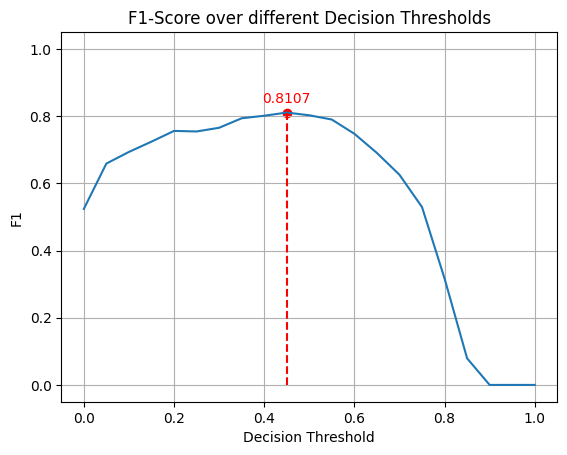

In [96]:
# Plot the array
plt.plot(torch.linspace(0, 1, steps=21), f1_scores_over_thresholds)

max_index = np.argmax(f1_scores_over_thresholds)
max_value = f1_scores_over_thresholds[max_index]

max_threshold = decision_thresholds[max_index]

plt.scatter(max_threshold, max_value, color='red')
plt.plot([max_threshold, max_threshold], [0, max_value], linestyle='--', color='red')
plt.text(max_threshold, max_value+0.02, f'{max_value:.4f}', va='bottom', ha='center', color='red')



# Add labels and title
plt.xlabel('Decision Threshold')
plt.ylabel('F1')
plt.title('F1-Score over different Decision Thresholds')
plt.ylim([-0.05, 1.05])
plt.grid(True)

# Show the plot
plt.show()

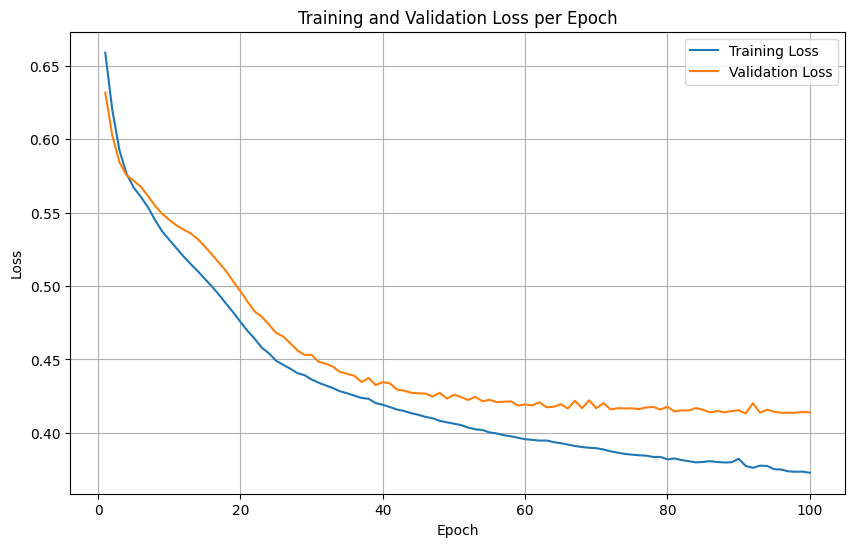

In [92]:
import matplotlib.pyplot as plt

epochs = list(range(1, n_epochs + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0.3,0.4)
plt.legend()
plt.grid(True)
plt.show()

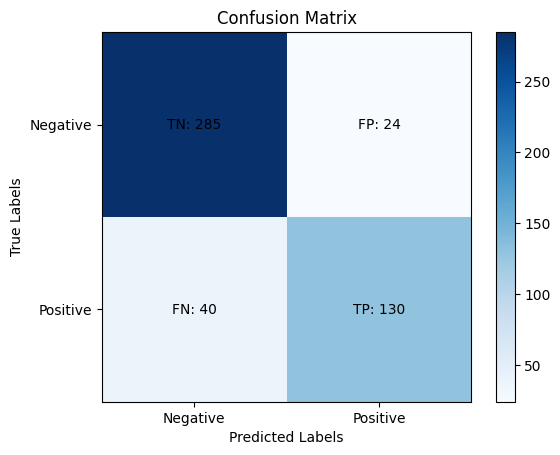

In [98]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(tn, fp, fn, tp):
    confusion_matrix = [[tn, fp], [fn, tp]]
    confusion_matrix_labels = [['TN', 'FP'], ['FN', 'TP']]

    # Plotting the confusion matrix
    plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])

    # Annotate each cell with respective counts
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f'{confusion_matrix_labels[i][j]}: {confusion_matrix[i][j]}', horizontalalignment='center', verticalalignment='center', color='black')

    plt.show()

plot_confusion_matrix(*test_conf_mat)
